In [101]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats 
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report, 
    roc_auc_score, roc_curve, auc,
    ConfusionMatrixDisplay, RocCurveDisplay,
    PrecisionRecallDisplay, precision_recall_curve,
    make_scorer, average_precision_score,
    f1_score
)
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Input
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from tensorflow_addons.metrics import F1Score
from keras_tuner import HyperModel, RandomSearch, Objective
from scikeras.wrappers import KerasClassifier



from imblearn.pipeline import Pipeline, make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from skimpy import skim


ModuleNotFoundError: No module named 'tensorflow_addons'

In [2]:
df_train = pd.read_csv("../data/train.csv")

In [3]:
df_test = pd.read_csv("../data/test.csv")

## Converting categorical data to numeric features and normalising

In [4]:
columns_to_encode = ['home_ownership','verification_status','purpose','application_type','sub_grade']

In [5]:
# One-hot encoding 
df_train = pd.get_dummies(df_train, columns=columns_to_encode)
df_test = pd.get_dummies(df_test, columns=columns_to_encode)

In [6]:
target_column = 'loan_status'  # Replace with your actual target variable name

class_mapping = {'Fully Paid': 0, 'Charged Off': 1}  

# Apply binary encoding to the target variable in the training DataFrame
df_train['Label'] = df_train[target_column].map(class_mapping)
df_test['Label'] = df_test[target_column].map(class_mapping)

In [7]:
print(df_train.shape)
print(df_train['Label'].value_counts(normalize=True) * 100)
print(df_test.shape)
print(df_test['Label'].value_counts(normalize=True) * 100)

(223591, 73)
Label
0    80.224159
1    19.775841
Name: proportion, dtype: float64
(112456, 74)
Label
0    80.279398
1    19.720602
Name: proportion, dtype: float64


In [8]:
df_train['purpose_educational'] = False


In [9]:
train_columns = df_train.columns
test_columns = df_test.columns

if set(train_columns) == set(test_columns):
    print("All columns match.")
else:
    print("Columns do not match.")


All columns match.


In [11]:
X_train = df_train.drop(['Label','loan_status'], axis=1)
y_train = df_train['Label']
X_test = df_test.drop(['Label','loan_status'], axis=1)
y_test = df_test['Label']
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
scaler = RobustScaler()
X_train_robust = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

scaler = StandardScaler()
X_train_standard = scaler.fit_transform(X_train)
X_test_standard = scaler.transform(X_test)

scaler = MinMaxScaler()
X_train_minmax = scaler.fit_transform(X_train)
X_test_minmax = scaler.transform(X_test)

In [13]:
def evaluate_nn(true, pred_probs, train=True):
    # For binary classification problems, threshold probabilities at 0.5 to get class predictions
    pred_class = (pred_probs > 0.5).astype(int)

    auprc_base = average_precision_score(true, pred_probs)

    if train:
        print("Train Result:\n================================================")
    else:
        print("Test Result:\n================================================")

    acc = accuracy_score(true, pred_class) * 100
    clf_report = pd.DataFrame(classification_report(true, pred_class, output_dict=True))
    cm = confusion_matrix(true, pred_class)

    print(f"Accuracy Score: {acc:.2f}%")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{clf_report}")
    print("_______________________________________________")
    print(f"Confusion Matrix: \n {cm}\n")
    print(f"Area Under the Precision-Recall Curve (AUPRC): {auprc_base:.4f}")


In [23]:
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

## Basic Models

In [54]:
model = Sequential()

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(100,activation='relu'))
model.add(Dropout(0.1))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(0.001), loss='binary_crossentropy', metrics=[AUC(name='AUC')])

#### robust_basic

In [55]:
r_robust = model.fit(x=X_train_robust, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_robust, y_test))

Epoch 1/20
6988/6988 - 18s - 3ms/step - AUC: 0.7987 - loss: 0.3718 - val_AUC: 0.8469 - val_loss: 0.3314
Epoch 2/20
6988/6988 - 14s - 2ms/step - AUC: 0.8752 - loss: 0.2977 - val_AUC: 0.8840 - val_loss: 0.2831
Epoch 3/20
6988/6988 - 15s - 2ms/step - AUC: 0.8846 - loss: 0.2833 - val_AUC: 0.8850 - val_loss: 0.2805
Epoch 4/20
6988/6988 - 16s - 2ms/step - AUC: 0.8868 - loss: 0.2801 - val_AUC: 0.8867 - val_loss: 0.2786
Epoch 5/20
6988/6988 - 15s - 2ms/step - AUC: 0.8884 - loss: 0.2784 - val_AUC: 0.8867 - val_loss: 0.2796
Epoch 6/20
6988/6988 - 16s - 2ms/step - AUC: 0.8890 - loss: 0.2777 - val_AUC: 0.8870 - val_loss: 0.2794
Epoch 7/20
6988/6988 - 16s - 2ms/step - AUC: 0.8904 - loss: 0.2757 - val_AUC: 0.8873 - val_loss: 0.2829
Epoch 8/20
6988/6988 - 15s - 2ms/step - AUC: 0.8904 - loss: 0.2762 - val_AUC: 0.8873 - val_loss: 0.2794
Epoch 9/20
6988/6988 - 15s - 2ms/step - AUC: 0.8916 - loss: 0.2747 - val_AUC: 0.8877 - val_loss: 0.2809
Epoch 10/20
6988/6988 - 15s - 2ms/step - AUC: 0.8926 - loss: 0.2

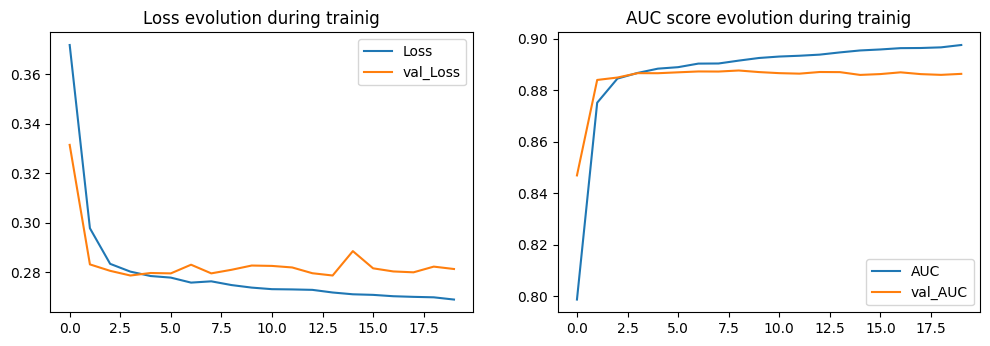

In [56]:
plot_learning_evolution(r_robust)

In [57]:
y_test_pred_robust = model.predict(X_test)
evaluate_nn(y_test, y_test_pred_robust, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 3s 898us/step
Test Result:
Accuracy Score: 30.65%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.998540      0.221313  0.306538       0.609927       0.845266
recall         0.136388      0.999188  0.306538       0.567788       0.306538
f1-score       0.239996      0.362365  0.306538       0.301181       0.264128
support    90279.000000  22177.000000  0.306538  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[12313 77966]
 [   18 22159]]

Area Under the Precision-Recall Curve (AUPRC): 0.2213


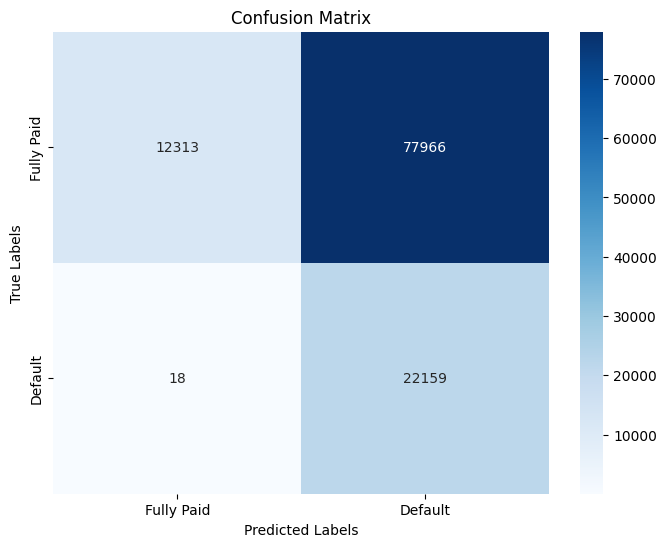

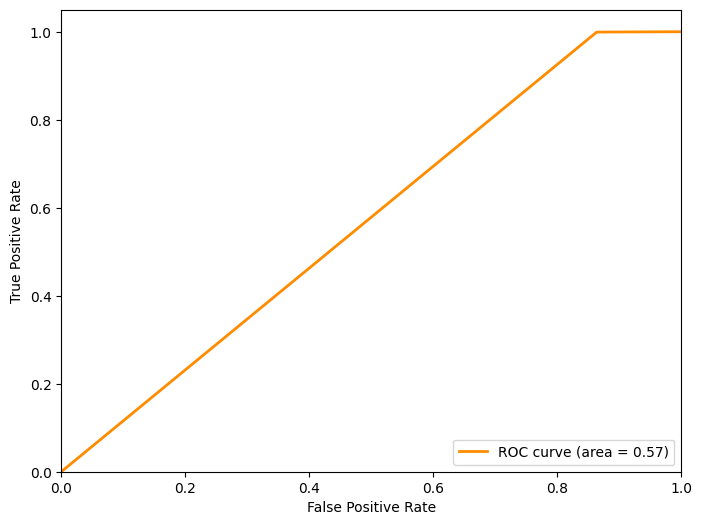

0.13559880919329692


In [58]:
y_pred_op = (y_test_pred_robust > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_robust)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_robust)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

#### standard_basic

In [59]:
r_standard = model.fit(x=X_train_standard, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_standard, y_test))

Epoch 1/20
6988/6988 - 14s - 2ms/step - AUC: 0.8381 - loss: 0.3869 - val_AUC: 0.8727 - val_loss: 0.2975
Epoch 2/20
6988/6988 - 13s - 2ms/step - AUC: 0.8750 - loss: 0.2990 - val_AUC: 0.8795 - val_loss: 0.2895
Epoch 3/20
6988/6988 - 14s - 2ms/step - AUC: 0.8807 - loss: 0.2909 - val_AUC: 0.8809 - val_loss: 0.2861
Epoch 4/20
6988/6988 - 19s - 3ms/step - AUC: 0.8845 - loss: 0.2863 - val_AUC: 0.8831 - val_loss: 0.2849
Epoch 5/20
6988/6988 - 20s - 3ms/step - AUC: 0.8859 - loss: 0.2836 - val_AUC: 0.8842 - val_loss: 0.2841
Epoch 6/20
6988/6988 - 19s - 3ms/step - AUC: 0.8875 - loss: 0.2818 - val_AUC: 0.8854 - val_loss: 0.2813
Epoch 7/20
6988/6988 - 14s - 2ms/step - AUC: 0.8884 - loss: 0.2801 - val_AUC: 0.8861 - val_loss: 0.2799
Epoch 8/20
6988/6988 - 15s - 2ms/step - AUC: 0.8897 - loss: 0.2791 - val_AUC: 0.8866 - val_loss: 0.2791
Epoch 9/20
6988/6988 - 15s - 2ms/step - AUC: 0.8908 - loss: 0.2778 - val_AUC: 0.8869 - val_loss: 0.2797
Epoch 10/20
6988/6988 - 16s - 2ms/step - AUC: 0.8913 - loss: 0.2

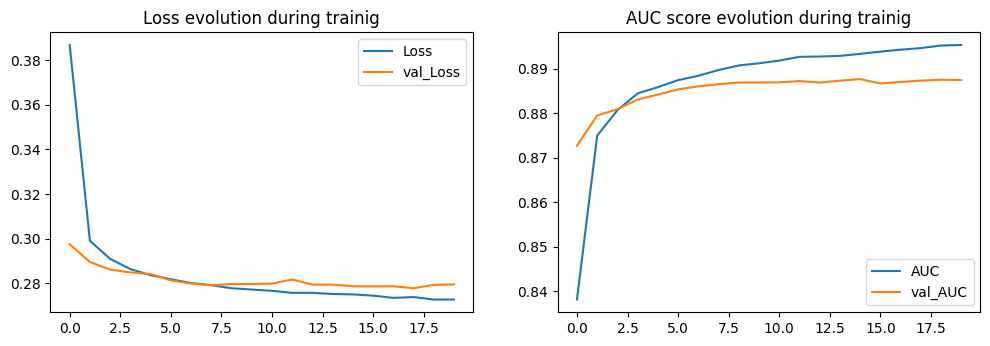

In [60]:
plot_learning_evolution(r_standard)

In [102]:
y_test_pred_standard = model.predict(X_test_robust)
evaluate_nn(y_test, y_test_pred_standard, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step
Test Result:
Accuracy Score: 75.45%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.853063      0.385492  0.754535       0.619277       0.760855
recall         0.838700      0.411913  0.754535       0.625307       0.754535
f1-score       0.845820      0.398265  0.754535       0.622043       0.757560
support    90279.000000  22177.000000  0.754535  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[75717 14562]
 [13042  9135]]

Area Under the Precision-Recall Curve (AUPRC): 0.3229


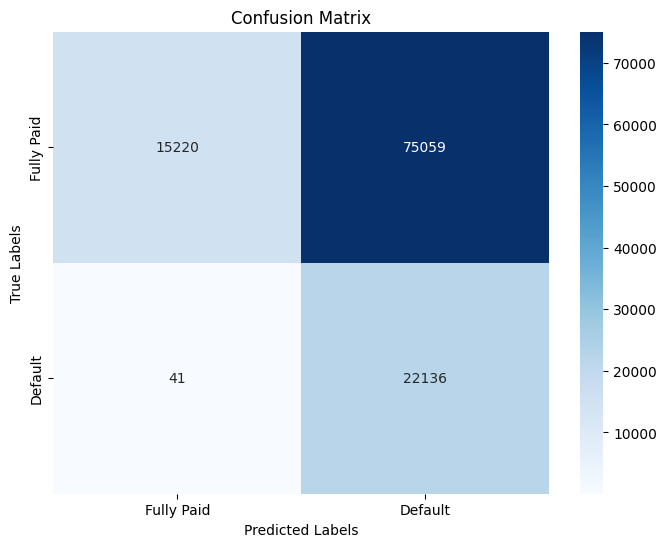

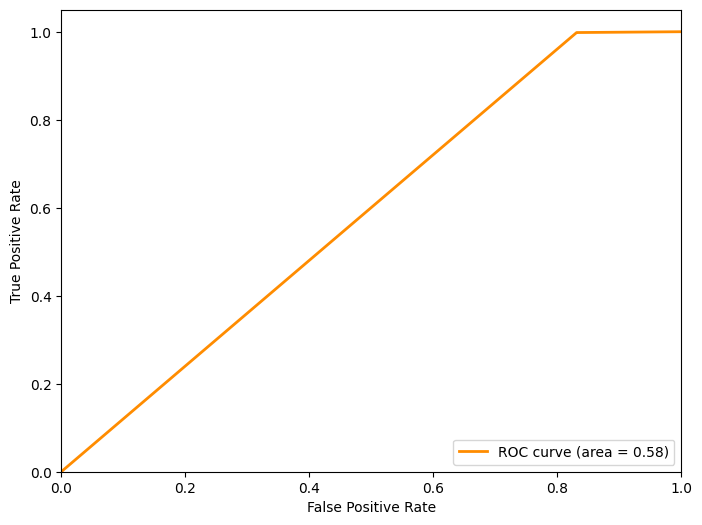

0.16696126003317358


In [62]:
y_pred_op = (y_test_pred_standard > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_standard)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_standard)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

#### minmax_basic

In [63]:
r_minmax = model.fit(x=X_train_minmax, y=y_train, epochs=20,verbose = 2,batch_size=32, validation_data=(X_test_minmax, y_test))

Epoch 1/20
6988/6988 - 15s - 2ms/step - AUC: 0.8314 - loss: 0.3395 - val_AUC: 0.8804 - val_loss: 0.2862
Epoch 2/20
6988/6988 - 15s - 2ms/step - AUC: 0.8812 - loss: 0.2856 - val_AUC: 0.8829 - val_loss: 0.2809
Epoch 3/20
6988/6988 - 14s - 2ms/step - AUC: 0.8851 - loss: 0.2798 - val_AUC: 0.8857 - val_loss: 0.2790
Epoch 4/20
6988/6988 - 21s - 3ms/step - AUC: 0.8873 - loss: 0.2776 - val_AUC: 0.8862 - val_loss: 0.2796
Epoch 5/20
6988/6988 - 15s - 2ms/step - AUC: 0.8882 - loss: 0.2765 - val_AUC: 0.8868 - val_loss: 0.2812
Epoch 6/20
6988/6988 - 14s - 2ms/step - AUC: 0.8894 - loss: 0.2755 - val_AUC: 0.8866 - val_loss: 0.2803
Epoch 7/20
6988/6988 - 12s - 2ms/step - AUC: 0.8902 - loss: 0.2748 - val_AUC: 0.8874 - val_loss: 0.2811
Epoch 8/20
6988/6988 - 12s - 2ms/step - AUC: 0.8908 - loss: 0.2744 - val_AUC: 0.8863 - val_loss: 0.2831
Epoch 9/20
6988/6988 - 13s - 2ms/step - AUC: 0.8913 - loss: 0.2739 - val_AUC: 0.8882 - val_loss: 0.2794
Epoch 10/20
6988/6988 - 12s - 2ms/step - AUC: 0.8921 - loss: 0.2

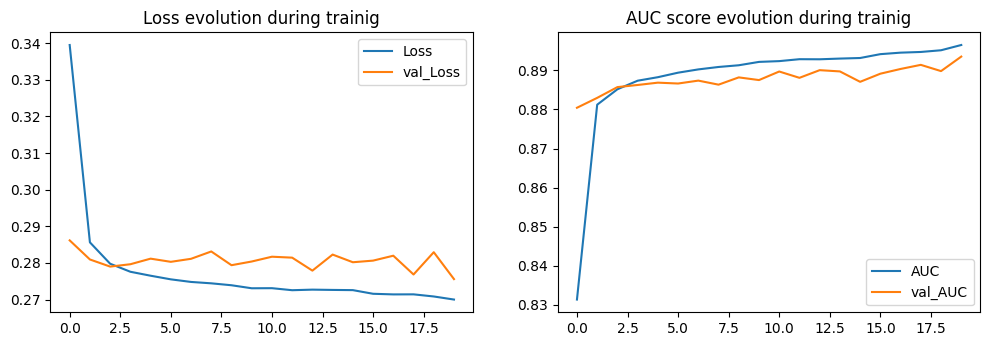

In [64]:
plot_learning_evolution(r_minmax)

In [65]:
y_test_pred_minmax = model.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_minmax, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 3s 825us/step
Test Result:
Accuracy Score: 29.59%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.999460      0.218765  0.295894       0.609113       0.845502
recall         0.122996      0.999729  0.295894       0.561363       0.295894
f1-score       0.219038      0.358978  0.295894       0.289008       0.246635
support    90279.000000  22177.000000  0.295894  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[11104 79175]
 [    6 22171]]

Area Under the Precision-Recall Curve (AUPRC): 0.2188


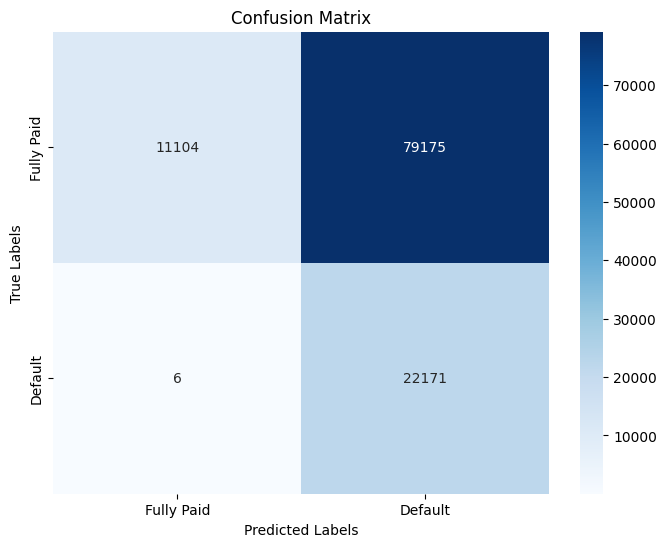

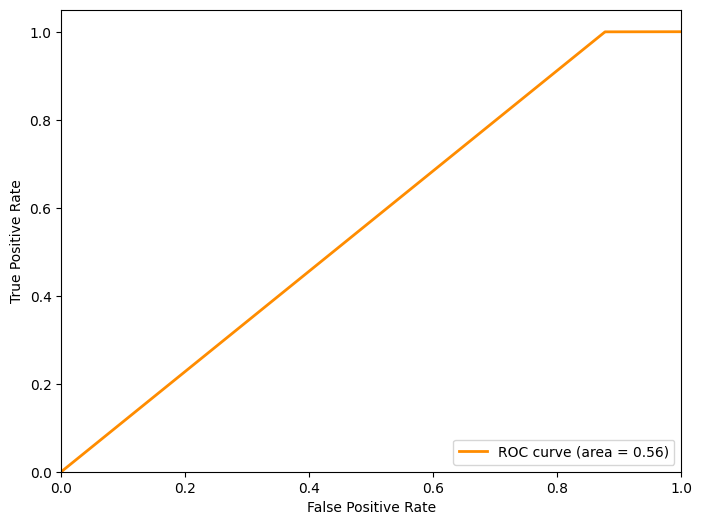

0.12272593809251187


In [66]:
y_pred_op = (y_test_pred_minmax > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_minmax)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_minmax)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

### overall PRC curves

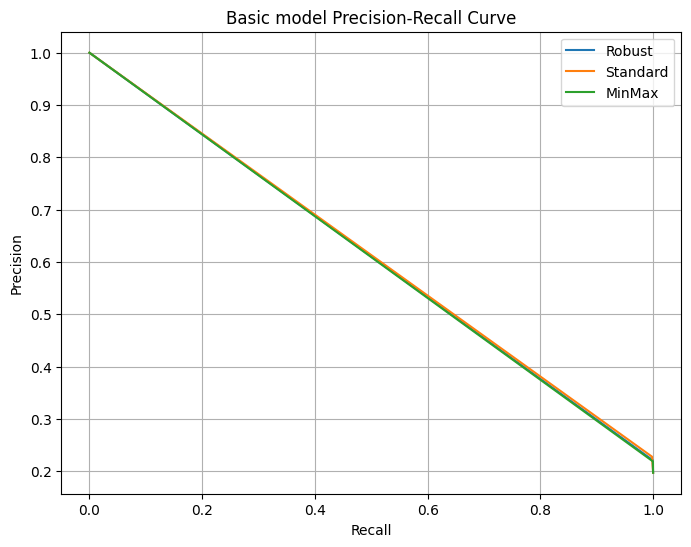

In [67]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

for y_pred, y_true, label in zip([y_test_pred_robust, y_test_pred_standard, y_test_pred_minmax],[y_test, y_test, y_test], ['Robust', 'Standard', 'MinMax']):
    # Compute precision-recall curve
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    
    # Plot precision-recall curve
    plt.plot(recall, precision, label=label)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Basic model Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Optimisation

## F1- weighted

only using minmax scaling

In [83]:
def create_model(n_units=32, dropout_rate=0.1, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(X_train_minmax.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['AUC'])
    return model


In [84]:
keras_clf = KerasClassifier(build_fn=create_model, epochs=20, batch_size=32, verbose=0,
                             n_units=32, dropout_rate=0.1, learning_rate=0.001)

In [85]:
pipeline = Pipeline([
    ('classifier', keras_clf)
])

In [86]:
param_grid = {
    'classifier__n_units': [32, 64, 128],
    'classifier__dropout_rate': [0.2, 0.3, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [87]:
nn_tuning_f1 = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1_weighted')

r_nn_tuning_f1= nn_tuning_f1.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\

In [103]:
y_test_pred_f1 = nn_tuning_f1.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_f1, train=False)

Test Result:
Accuracy Score: 88.65%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.877931      0.975654  0.886533       0.926793       0.897203
recall         0.997330      0.435496  0.886533       0.716413       0.886533
f1-score       0.933830      0.602195  0.886533       0.768012       0.868429
support    90279.000000  22177.000000  0.886533  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90038   241]
 [12519  9658]]

Area Under the Precision-Recall Curve (AUPRC): 0.5362


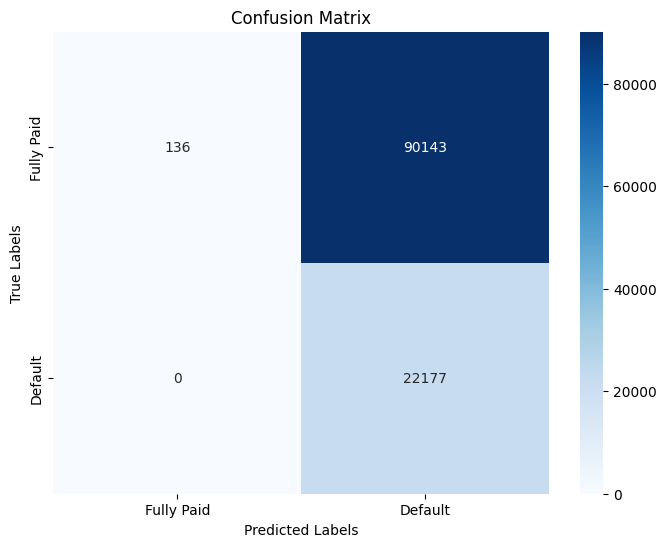

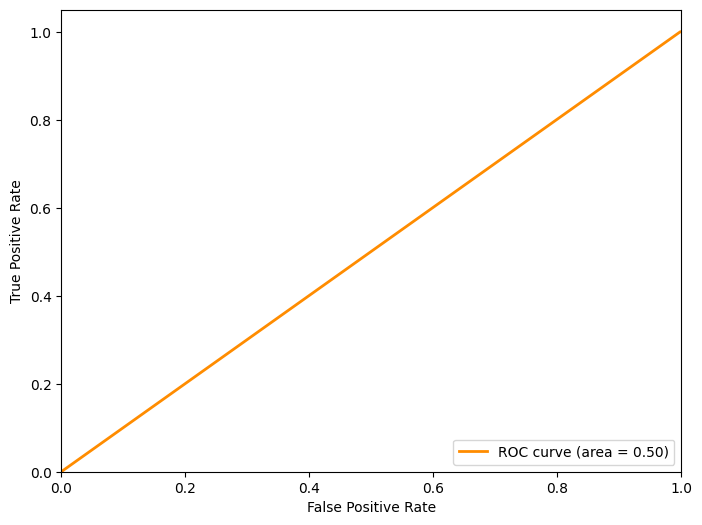

0.0015064411435660174


In [98]:
y_pred_op_f1 = (y_test_pred_f1 > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op_f1)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_test_pred_f1)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_test_pred_f1)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

## AUC: PRC

In [88]:
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

nn_tuning_prc = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

r_nn_tuning_prc= nn_tuning_prc.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan

In [104]:
y_test_pred_prc = nn_tuning_prc.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_prc, train=False)

Test Result:
Accuracy Score: 88.67%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.876857      0.992899  0.886738       0.934878       0.899741
recall         0.999247      0.428732  0.886738       0.713990       0.886738
f1-score       0.934060      0.598873  0.886738       0.766466       0.867959
support    90279.000000  22177.000000  0.886738  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90211    68]
 [12669  9508]]

Area Under the Precision-Recall Curve (AUPRC): 0.5383


# undersampling

## F1

In [105]:
def create_model_under(n_units=32, dropout_rate=0.1, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(X_train_minmax.shape[1],)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['AUC'])
    return model


In [106]:
keras_clf_under = KerasClassifier(build_fn=create_model_under, epochs=20, batch_size=32, verbose=0,
                             n_units=32, dropout_rate=0.1, learning_rate=0.001)

In [107]:
pipeline_under = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', keras_clf_under)
])

In [108]:
param_grid = {
    'classifier__n_units': [32, 64, 128],
    'classifier__dropout_rate': [0.1, 0.2, 0.3, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [109]:
nn_tuning_f1_under = RandomizedSearchCV(estimator=pipeline_under,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

r_nn_tuning_f1_under= nn_tuning_f1_under.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\

In [110]:
y_test_pred_f1_under = nn_tuning_f1_under.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_f1_under, train=False)

Test Result:
Accuracy Score: 77.54%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.937520      0.459679  0.775441       0.698600       0.843287
recall         0.771708      0.790639  0.775441       0.781173       0.775441
f1-score       0.846571      0.581356  0.775441       0.713964       0.794269
support    90279.000000  22177.000000  0.775441  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[69669 20610]
 [ 4643 17534]]

Area Under the Precision-Recall Curve (AUPRC): 0.4047


## AUC:PRC

In [111]:
auprc_scorer = make_scorer(average_precision_score, needs_proba=True)

nn_tuning_prc_under = RandomizedSearchCV(estimator=pipeline_under,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring=auprc_scorer)

r_nn_tuning_prc_under = nn_tuning_prc_under.fit(X_train_minmax, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_scorer.py:548: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan

In [112]:
y_test_pred_prc_under = nn_tuning_prc_under.predict(X_test_minmax)
evaluate_nn(y_test, y_test_pred_prc_under, train=False)

Test Result:
Accuracy Score: 80.15%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.930076      0.497758   0.80146       0.713917       0.844820
recall         0.813877      0.750913   0.80146       0.782395       0.801460
f1-score       0.868105      0.598673   0.80146       0.733389       0.814972
support    90279.000000  22177.000000   0.80146  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[73476 16803]
 [ 5524 16653]]

Area Under the Precision-Recall Curve (AUPRC): 0.4229


# [old] undersampling

### base

In [37]:
rus = RandomUnderSampler(random_state=42)

In [17]:
X_under, y_under = rus.fit_resample(X_train, y_train)

In [18]:
print(X_under.shape)
print(y_under.shape)

(88434, 72)
(88434,)


In [19]:
print('Fully Paid:', y_under.value_counts()[0], '/', round(y_under.value_counts()[0]/len(y_under) * 100,2), '% of the dataset')
print('Charged Off:', y_under.value_counts()[1], '/',round(y_under.value_counts()[1]/len(y_under) * 100,2), '% of the dataset')

Fully Paid: 44217 / 50.0 % of the dataset
Charged Off: 44217 / 50.0 % of the dataset


In [39]:
model = Sequential()

model.add(Dense(78,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(39,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(19,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer="adam", loss='binary_crossentropy')

In [42]:
keras_clf = KerasClassifier(build_fn=model, epochs=20, batch_size=256, verbose=1)

In [43]:
pipeline = Pipeline([
    ('undersample', rus),
    ('classifier', keras_clf)  # Use the wrapped Keras model
])

In [44]:
pipeline.fit(X_train, y_train)

Epoch 1/20


c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


346/346 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5339
Epoch 2/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5264
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5196
Epoch 4/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.5171
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.5132
Epoch 6/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4931
Epoch 7/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4670
Epoch 8/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4499
Epoch 9/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4322
Epoch 10/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4215
Epoch 11/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4134
Epoch 12/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.4078
Epoch 13/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.4023
Epoch 14/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3998
Epoch 15/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.3993


Pipeline(steps=[('undersample', RandomUnderSampler(random_state=42)),
                ('classifier',
                 KerasClassifier(batch_size=256, build_fn=<Sequential name=sequential_5, built=True>, epochs=20))])

In [47]:
y_pred_base_under = pipeline.predict(X_test)  
evaluate_nn(y_test, y_pred_base_under, train=False)

440/440 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
Test Result:
Accuracy Score: 80.70%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.929670      0.507180  0.806965       0.718425       0.846352
recall         0.821708      0.746945  0.806965       0.784327       0.806965
f1-score       0.872361      0.604143  0.806965       0.738252       0.819467
support    90279.000000  22177.000000  0.806965  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[74183 16096]
 [ 5612 16565]]

Area Under the Precision-Recall Curve (AUPRC): 0.4287


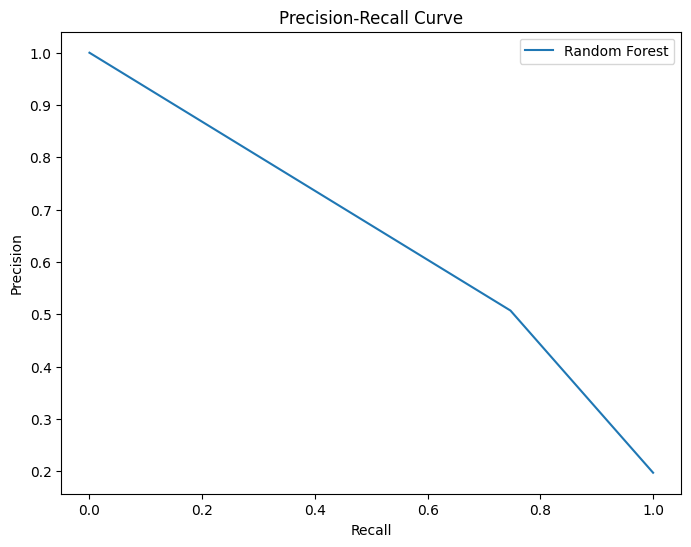

In [49]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_base_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

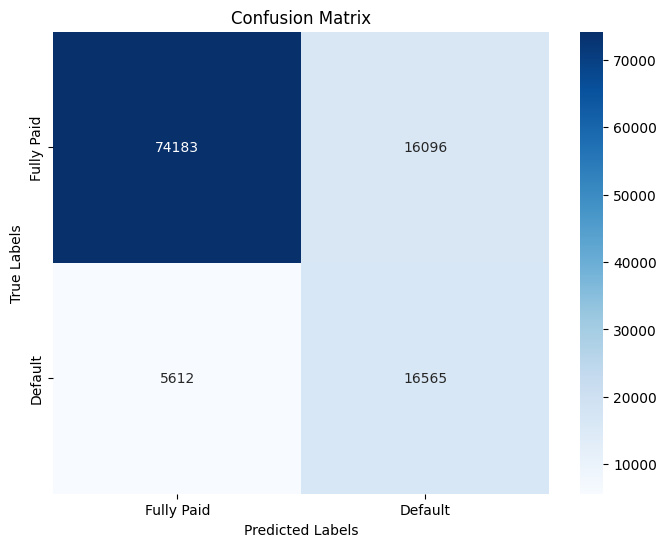

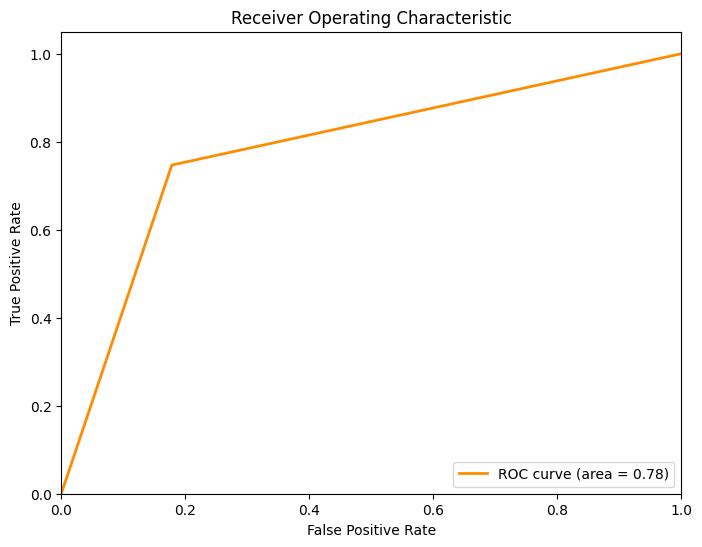

In [50]:
y_pred_base_under_int = (y_pred_base_under > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_base_under_int)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_base_under_int)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [51]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.5686532930921563

### model tuning (AUC: PRC)

In [62]:
def create_model(n_units=32, dropout_rate=0.2, learning_rate=0.001):
    model = Sequential()
    model.add(Dense(n_units, activation='relu', input_shape=(input_shape,)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_units // 2, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [72]:
keras_clf_op = KerasClassifier(build_fn=create_model, epochs=25, batch_size=32, verbose=0,
                             n_units=32, dropout_rate=0.2, learning_rate=0.001)

In [73]:
param_grid = {
    'classifier__n_units': [32, 64, 128],
    'classifier__dropout_rate': [0.2, 0.3, 0.5],
    'classifier__learning_rate': [0.01, 0.001, 0.0001]
}

In [74]:
pipeline = Pipeline([
    ('undersample', RandomUnderSampler(random_state=42)),
    ('classifier', keras_clf_op)
])

In [75]:
random_search_under = RandomizedSearchCV(estimator=pipeline,
                                   param_distributions=param_grid,
                                   n_iter=10,
                                   cv=3,
                                   random_state=42,
                                   scoring='f1')

random_search_under.fit(X_train, y_train)

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\scikeras\wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('undersample',
                                              RandomUnderSampler(random_state=42)),
                                             ('classifier',
                                              KerasClassifier(batch_size=32, build_fn=<function create_model at 0x00000184BD6D89A0>, dropout_rate=0.2, epochs=50, learning_rate=0.001, n_units=32, verbose=0))]),
                   param_distributions={'classifier__dropout_rate': [0.2, 0.3,
                                                                     0.5],
                                        'classifier__learning_rate': [0.01,
                                                                      0.001,
                                                                      0.0001],
                                        'classifier__n_units': [32, 64, 128]},
                   random_state=42, scoring='f1')

In [76]:
print("Best Parameters:", random_search_under.best_params_)
print("Best Score:", random_search_under.best_score_)

Best Parameters: {'classifier__n_units': 128, 'classifier__learning_rate': 0.0001, 'classifier__dropout_rate': 0.2}
Best Score: 0.6041578759021996


In [77]:
y_pred_base_under = random_search_under.predict(X_test)  
evaluate_nn(y_test, y_pred_base_under, train=False)

Test Result:
Accuracy Score: 79.52%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.934035      0.487754  0.795173       0.710894       0.846025
recall         0.801460      0.769581  0.795173       0.785521       0.795173
f1-score       0.862684      0.597082  0.795173       0.729883       0.810305
support    90279.000000  22177.000000  0.795173  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[72355 17924]
 [ 5110 17067]]

Area Under the Precision-Recall Curve (AUPRC): 0.4208


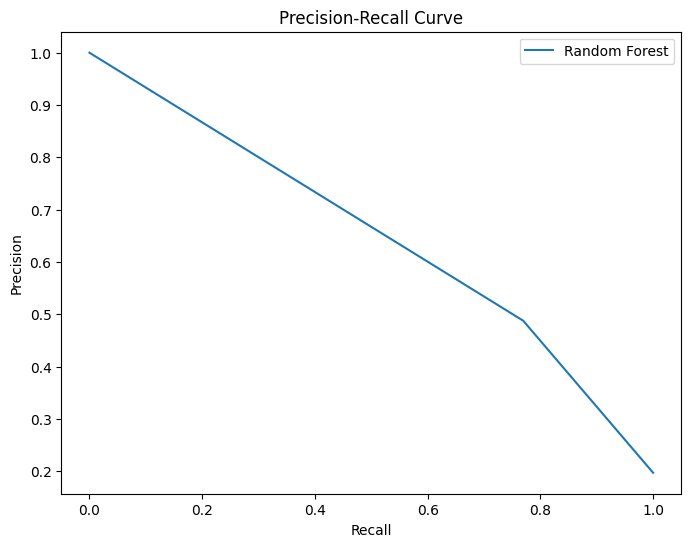

In [78]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_base_under)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

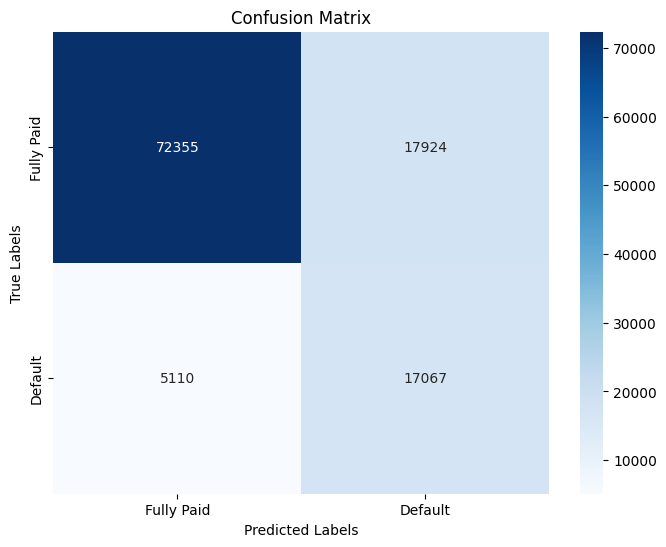

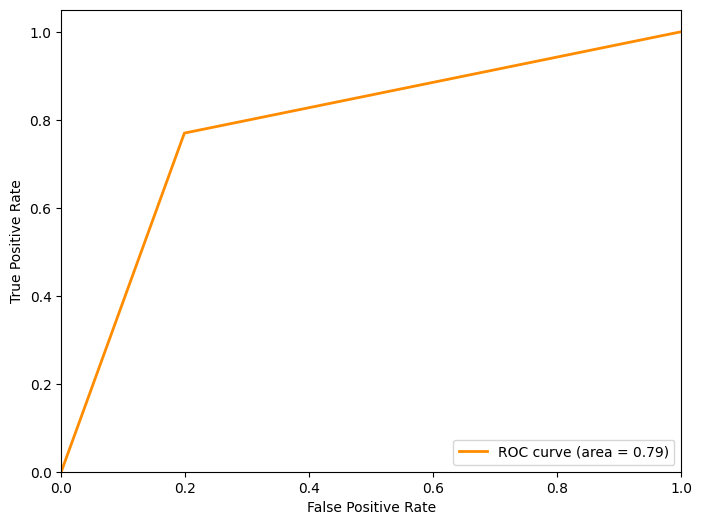

In [79]:
y_pred_base_under_int = (y_pred_base_under > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_base_under_int)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_pred_base_under_int)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.show()

In [80]:
# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_base_under)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

ks

0.571041016229966

## [old] optimisation - full data 

In [ ]:
class MyHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(self.input_shape,)))  # Correct usage of input_shape

        # First dense layer
        model.add(Dense(units=hp.Int('units_input', 32, 512, step=32),
                        activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_input', 0.0, 0.5, step=0.1)))

        # Additional hidden layers
        for i in range(hp.Int('num_layers', 1, 5)):
            model.add(Dense(units=hp.Int(f'units_layer{i}', 32, 512, step=32),
                            activation='relu'))
            model.add(Dropout(rate=hp.Float(f'dropout_layer{i}', 0.0, 0.5, step=0.1)))

        # Output layer for binary classification
        model.add(Dense(1, activation='sigmoid'))

        # Compile model with AUC-PR as a metric
        model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                      loss='binary_crossentropy',
                      metrics=[AUC(curve='PR', name='auc_pr')])

        return model

In [ ]:
input_shape = X_train.shape[1]  # Assuming X_train is already defined
hypermodel = MyHyperModel(input_shape=input_shape)

# Configure the RandomSearch tuner
tuner = RandomSearch(
    hypermodel,
    objective=Objective("val_auc_pr", direction="max"),
    max_trials=10,
    executions_per_trial=2,
    directory='model_tuning',
    project_name='auc_pr_tuning'
)

Reloading Tuner from model_tuning\auc_pr_tuning\tuner0.json


In [ ]:
tuner.search(x=X_train, y=y_train, epochs=10, validation_split=0.2, verbose=2)

Trial 10 Complete [00h 03m 53s]
val_auc_pr: 0.6634253263473511

Best val_auc_pr So Far: 0.7549607455730438
Total elapsed time: 01h 00m 17s


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

c:\Users\winyan\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\saving\saving_lib.py:418: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


In [ ]:
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

print("Best hyperparameters:")
for key, value in best_hp.values.items():
    print(f"{key}: {value}")


Best hyperparameters:
units_input: 256
dropout_input: 0.4
num_layers: 4
units_layer0: 288
dropout_layer0: 0.1
learning_rate: 0.001
units_layer1: 416
dropout_layer1: 0.0
units_layer2: 96
dropout_layer2: 0.1
units_layer3: 32
dropout_layer3: 0.1


In [ ]:
rebuilt_best_model = hypermodel.build(best_hp)
r = rebuilt_best_model.fit(X_train, y_train, epochs=10, validation_split=0.2, verbose=2)

Epoch 1/10
5590/5590 - 25s - 4ms/step - auc_pr: 0.5874 - loss: 0.3885 - val_auc_pr: 0.6298 - val_loss: 0.3561
Epoch 2/10
5590/5590 - 20s - 4ms/step - auc_pr: 0.6281 - loss: 0.3644 - val_auc_pr: 0.6307 - val_loss: 0.3560
Epoch 3/10
5590/5590 - 21s - 4ms/step - auc_pr: 0.6693 - loss: 0.3377 - val_auc_pr: 0.7499 - val_loss: 0.2824
Epoch 4/10
5590/5590 - 21s - 4ms/step - auc_pr: 0.7410 - loss: 0.2924 - val_auc_pr: 0.7525 - val_loss: 0.2775
Epoch 5/10
5590/5590 - 19s - 3ms/step - auc_pr: 0.7478 - loss: 0.2877 - val_auc_pr: 0.7534 - val_loss: 0.2799
Epoch 6/10
5590/5590 - 19s - 3ms/step - auc_pr: 0.7509 - loss: 0.2855 - val_auc_pr: 0.7543 - val_loss: 0.2764
Epoch 7/10
5590/5590 - 24s - 4ms/step - auc_pr: 0.7526 - loss: 0.2839 - val_auc_pr: 0.7546 - val_loss: 0.2837
Epoch 8/10
5590/5590 - 23s - 4ms/step - auc_pr: 0.7532 - loss: 0.2832 - val_auc_pr: 0.7557 - val_loss: 0.2763
Epoch 9/10
5590/5590 - 25s - 5ms/step - auc_pr: 0.7543 - loss: 0.2828 - val_auc_pr: 0.7545 - val_loss: 0.2771
Epoch 10/1

In [ ]:
y_probs_op = rebuilt_best_model.predict(X_test)  
evaluate_nn(y_test, y_probs_op, train=False)

3515/3515 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
Test Result:
Accuracy Score: 88.72%
_______________________________________________
CLASSIFICATION REPORT:
                      0             1  accuracy      macro avg   weighted avg
precision      0.877795      0.986373  0.887218       0.932084       0.899207
recall         0.998527      0.434098  0.887218       0.716313       0.887218
f1-score       0.934276      0.602874  0.887218       0.768575       0.868922
support    90279.000000  22177.000000  0.887218  112456.000000  112456.000000
_______________________________________________
Confusion Matrix: 
 [[90146   133]
 [12550  9627]]

Area Under the Precision-Recall Curve (AUPRC): 0.7534


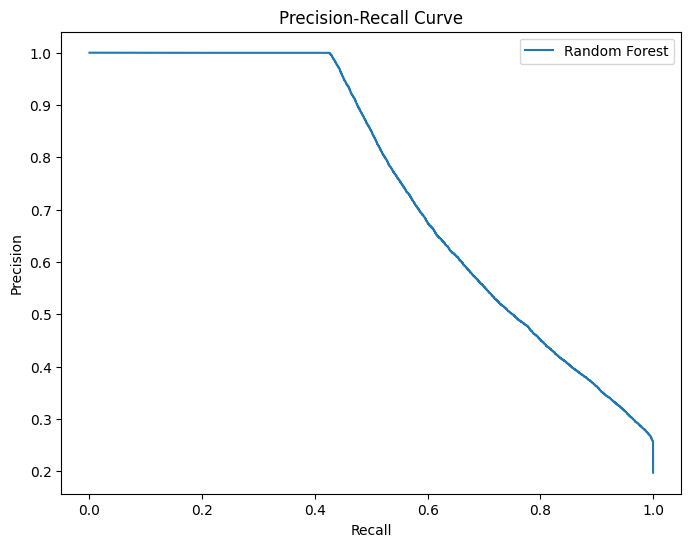

In [ ]:
precision, recall, _ = precision_recall_curve(y_test, y_probs_op)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label='Random Forest')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()

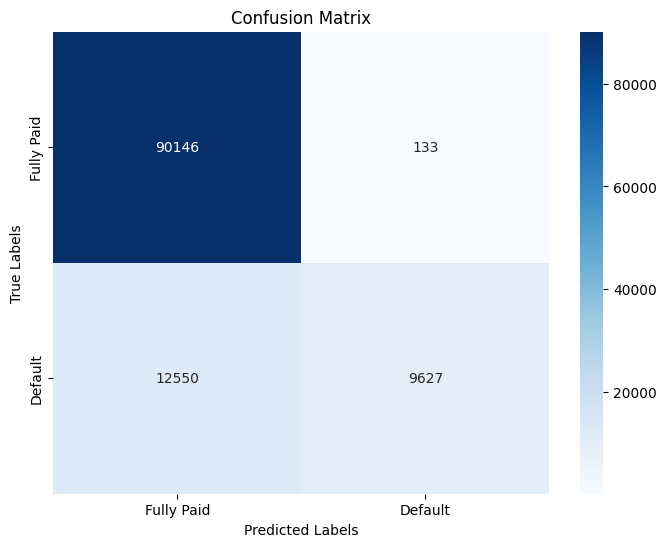

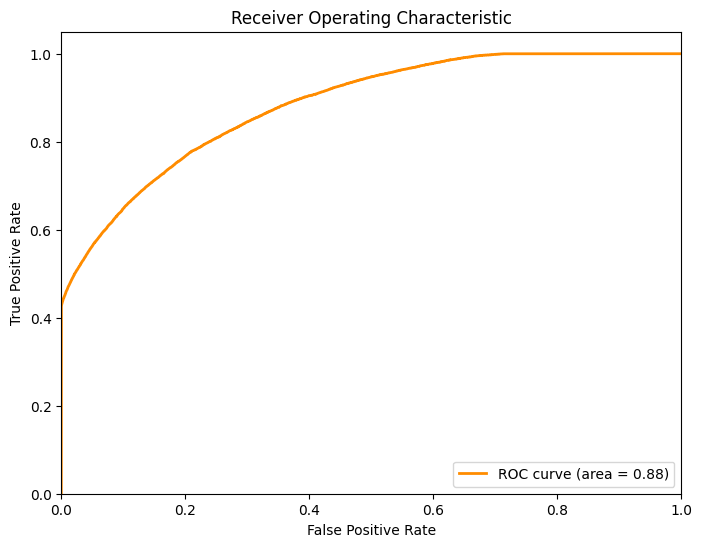

In [ ]:
y_pred_op = (y_probs_op > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred_op)

fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax)
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Fully Paid', 'Default'])
ax.yaxis.set_ticklabels(['Fully Paid', 'Default'])
plt.show()

fpr, tpr, _ = roc_curve(y_test, y_probs_op)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Calculate True Positive Rate (TPR) and False Positive Rate (FPR)
fpr, tpr, thresholds = roc_curve(y_test, y_probs_op)

# Calculate Kolmogorov-Smirnov measure (KS)
ks = max(tpr - fpr)

print(ks)

0.5682196312063087

## model 1

In [17]:
def evaluate_nn(true, pred, train=True):
    if train:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Train Result:\n================================================")
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
    elif train==False:
        clf_report = pd.DataFrame(classification_report(true, pred, output_dict=True))
        print("Test Result:\n================================================")        
        print(f"Accuracy Score: {accuracy_score(true, pred) * 100:.2f}%")
        print("_______________________________________________")
        print(f"CLASSIFICATION REPORT:\n{clf_report}")
        print("_______________________________________________")
        print(f"Confusion Matrix: \n {confusion_matrix(true, pred)}\n")
        
def plot_learning_evolution(r):
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.plot(r.history['loss'], label='Loss')
    plt.plot(r.history['val_loss'], label='val_Loss')
    plt.title('Loss evolution during trainig')
    plt.legend()

    plt.subplot(2, 2, 2)
    plt.plot(r.history['AUC'], label='AUC')
    plt.plot(r.history['val_AUC'], label='val_AUC')
    plt.title('AUC score evolution during trainig')
    plt.legend();

In [57]:
def nn_model(num_columns, num_labels, hidden_units, dropout_rates, learning_rate):
    inp = tf.keras.layers.Input(shape=(num_columns, ))
    x = BatchNormalization()(inp)
    x = Dropout(dropout_rates[0])(x)
    for i in range(len(hidden_units)):
        x = Dense(hidden_units[i], activation='relu')(x)
        x = BatchNormalization()(x)
        x = Dropout(dropout_rates[i + 1])(x)
    x = Dense(num_labels, activation='sigmoid')(x)
  
    model = Model(inputs=inp, outputs=x)
    model.compile(optimizer=Adam(learning_rate), loss='binary_crossentropy', metrics=[AUC(name='AUC')])
    return model

In [35]:
num_columns = X_train.shape[1]
num_labels = 1
hidden_units = [150, 150, 150]
dropout_rates = [0.1, 0, 0.1, 0]
learning_rate = 1e-3


model = nn_model(
    num_columns=num_columns, 
    num_labels=num_labels,
    hidden_units=hidden_units,
    dropout_rates=dropout_rates,
    learning_rate=learning_rate
)
r = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=20,
    batch_size=32
)

Epoch 1/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step - AUC: 0.7525 - loss: 0.4326 - val_AUC: 0.8363 - val_loss: 0.3418
Epoch 2/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8351 - loss: 0.3552 - val_AUC: 0.8440 - val_loss: 0.3443
Epoch 3/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 23s 3ms/step - AUC: 0.8483 - loss: 0.3393 - val_AUC: 0.8482 - val_loss: 0.3387
Epoch 4/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - AUC: 0.8526 - loss: 0.3344 - val_AUC: 0.8724 - val_loss: 0.3184
Epoch 5/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8542 - loss: 0.3316 - val_AUC: 0.8111 - val_loss: 0.3733
Epoch 6/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8558 - loss: 0.3275 - val_AUC: 0.8250 - val_loss: 0.3498
Epoch 7/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8562 - loss: 0.3262 - val_AUC: 0.7983 - val_loss: 0.4324
Epoch 8/20
6988/6988 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - AUC: 0.8577 - loss: 0.3243 - val_AUC: 0.8262 - val_loss: 0.3639
Epoch 9/20
6988/6988 ━━━━━━━━━━━

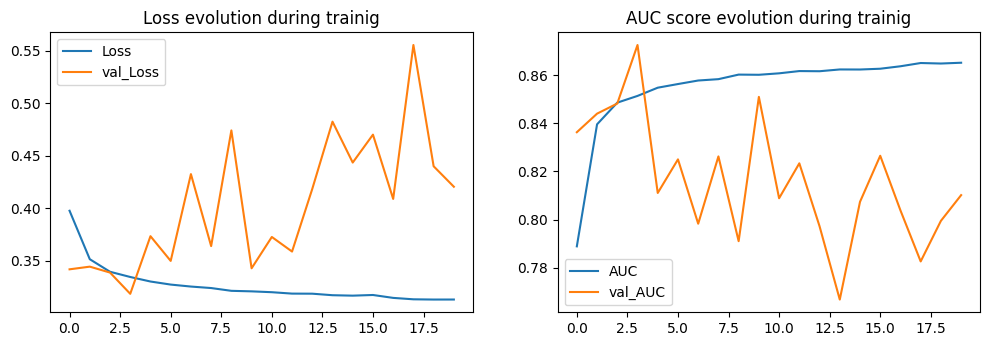

In [36]:
plot_learning_evolution(r)

In [37]:
y_train_pred = model.predict(X_train)
evaluate_nn(y_train, y_train_pred.round(), train=True)

6988/6988 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step
Train Result:
Accuracy Score: 85.16%
_______________________________________________
CLASSIFICATION REPORT:
                       0             1  accuracy      macro avg   weighted avg
precision       0.875904      0.689388    0.8516       0.782646       0.839019
recall          0.949547      0.454260    0.8516       0.701903       0.851600
f1-score        0.911240      0.547653    0.8516       0.729447       0.839338
support    179374.000000  44217.000000    0.8516  223591.000000  223591.000000
_______________________________________________
Confusion Matrix: 
 [[170324   9050]
 [ 24131  20086]]



In [ ]:
y_test_pred = model.predict(X_test)
evaluate_nn(y_test, y_test_pred.round(), train=False)